In [13]:
# from datetime import datetime
import os
import random
import sys
import copy
import pickle
import datetime
import csv

from argparse import ArgumentParser, Namespace
from pathlib import Path
from pprint import pprint
from collections import namedtuple, deque, Iterable

import psutil
from flatland.utils.rendertools import RenderTool
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from flatland.envs.rail_env import RailEnv, RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.envs.observations import TreeObsForRailEnv

from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters
from flatland.envs.predictions import ShortestPathPredictorForRailEnv

In [2]:
def max_lt(seq, val):
    """
    Return greatest item in seq for which item < val applies.
    None is returned if seq was empty or all items in seq were >= val.
    """
    max = 0
    idx = len(seq) - 1
    while idx >= 0:
        if seq[idx] < val and seq[idx] >= 0 and seq[idx] > max:
            max = seq[idx]
        idx -= 1
    return max


def min_gt(seq, val):
    """
    Return smallest item in seq for which item > val applies.
    None is returned if seq was empty or all items in seq were >= val.
    """
    min = np.inf
    idx = len(seq) - 1
    while idx >= 0:
        if seq[idx] >= val and seq[idx] < min:
            min = seq[idx]
        idx -= 1
    return min


def norm_obs_clip(obs, clip_min=-1, clip_max=1, fixed_radius=0, normalize_to_range=False):
    """
    This function returns the difference between min and max value of an observation
    :param obs: Observation that should be normalized
    :param clip_min: min value where observation will be clipped
    :param clip_max: max value where observation will be clipped
    :return: returnes normalized and clipped observatoin
    """
    if fixed_radius > 0:
        max_obs = fixed_radius
    else:
        max_obs = max(1, max_lt(obs, 1000)) + 1

    min_obs = 0  # min(max_obs, min_gt(obs, 0))
    if normalize_to_range:
        min_obs = min_gt(obs, 0)
    if min_obs > max_obs:
        min_obs = max_obs
    if max_obs == min_obs:
        return np.clip(np.array(obs) / max_obs, clip_min, clip_max)
    norm = np.abs(max_obs - min_obs)
    return np.clip((np.array(obs) - min_obs) / norm, clip_min, clip_max)


def _split_node_into_feature_groups(node) -> (np.ndarray, np.ndarray, np.ndarray):
    data = np.zeros(6)
    distance = np.zeros(1)
    agent_data = np.zeros(4)

    data[0] = node.dist_own_target_encountered
    data[1] = node.dist_other_target_encountered
    data[2] = node.dist_other_agent_encountered
    data[3] = node.dist_potential_conflict
    data[4] = node.dist_unusable_switch
    data[5] = node.dist_to_next_branch

    distance[0] = node.dist_min_to_target

    agent_data[0] = node.num_agents_same_direction
    agent_data[1] = node.num_agents_opposite_direction
    agent_data[2] = node.num_agents_malfunctioning
    agent_data[3] = node.speed_min_fractional

    return data, distance, agent_data


def _split_subtree_into_feature_groups(node, current_tree_depth: int, max_tree_depth: int) -> (np.ndarray, np.ndarray, np.ndarray):
    if node == -np.inf:
        remaining_depth = max_tree_depth - current_tree_depth
        # reference: https://stackoverflow.com/questions/515214/total-number-of-nodes-in-a-tree-data-structure
        num_remaining_nodes = int((4 ** (remaining_depth + 1) - 1) / (4 - 1))
        return [-np.inf] * num_remaining_nodes * 6, [-np.inf] * num_remaining_nodes, [-np.inf] * num_remaining_nodes * 4

    data, distance, agent_data = _split_node_into_feature_groups(node)

    if not node.childs:
        return data, distance, agent_data

    for direction in TreeObsForRailEnv.tree_explored_actions_char:
        sub_data, sub_distance, sub_agent_data = _split_subtree_into_feature_groups(node.childs[direction], current_tree_depth + 1, max_tree_depth)
        data = np.concatenate((data, sub_data))
        distance = np.concatenate((distance, sub_distance))
        agent_data = np.concatenate((agent_data, sub_agent_data))

    return data, distance, agent_data


def split_tree_into_feature_groups(tree, max_tree_depth: int) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    This function splits the tree into three difference arrays of values
    """
    data, distance, agent_data = _split_node_into_feature_groups(tree)

    for direction in TreeObsForRailEnv.tree_explored_actions_char:
        sub_data, sub_distance, sub_agent_data = _split_subtree_into_feature_groups(tree.childs[direction], 1, max_tree_depth)
        data = np.concatenate((data, sub_data))
        distance = np.concatenate((distance, sub_distance))
        agent_data = np.concatenate((agent_data, sub_agent_data))

    return data, distance, agent_data


def normalize_observation(observation, tree_depth: int, observation_radius=0):
    """
    This function normalizes the observation used by the RL algorithm
    """
    data, distance, agent_data = split_tree_into_feature_groups(observation, tree_depth)

    data = norm_obs_clip(data, fixed_radius=observation_radius)
    distance = norm_obs_clip(distance, normalize_to_range=True)
    agent_data = np.clip(agent_data, -1, 1)
    normalized_obs = np.concatenate((np.concatenate((data, distance)), agent_data))
    return normalized_obs

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, use_cuda, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.use_cuda     = use_cuda
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.use_cuda:
            weight_epsilon = self.weight_epsilon.cuda()
            bias_epsilon   = self.bias_epsilon.cuda()
        else:
            weight_epsilon = self.weight_epsilon
            bias_epsilon   = self.bias_epsilon
            
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(Variable(weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

In [4]:
class RainbowDQN(nn.Module):
    """Dueling Q-network (https://arxiv.org/abs/1511.06581)"""

    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()

        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 256)
        self.linear2 = nn.Linear(256, 512)

        if torch.cuda.is_available():
            USE_CUDA = True
        else:
            USE_CUDA = False
        
        self.noisy_value1 = NoisyLinear(512, 512, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(512, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(512, 512, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(512, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)

        

    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)

        return x

    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()

In [5]:
class Policy:
    def step(self, state, action, reward, next_state, done):
        raise NotImplementedError

    def act(self, state, eps=0.):
        raise NotImplementedError

    def save(self, filename):
        raise NotImplementedError

    def load(self, filename):
        raise NotImplementedError

In [6]:
class DDDQNPolicy(Policy):
    """Dueling Double DQN policy"""

    def __init__(self, state_size, action_size, parameters, evaluation_mode=False):
        self.evaluation_mode = evaluation_mode

        self.state_size = state_size
        self.action_size = action_size
        self.double_dqn = True
        self.hidsize = 64

        if not evaluation_mode:
            self.hidsize = parameters.hidden_size
            self.buffer_size = parameters.buffer_size
            self.batch_size = parameters.batch_size
            self.update_every = parameters.update_every
            self.learning_rate = parameters.learning_rate
            self.tau = parameters.tau
            self.gamma = parameters.gamma
            self.buffer_min_size = parameters.buffer_min_size
            self.Vmin = parameters.Vmin
            self.Vmax = parameters.Vmax

        # Device
        if parameters.use_gpu and torch.cuda.is_available():
            self.device = torch.device("cuda:0")
            # print("🐇 Using GPU")
        else:
            self.device = torch.device("cpu")
            # print("🐢 Using CPU")

        # Q-Network
        self.current_model = RainbowDQN(num_inputs = self.state_size, num_actions = self.action_size, num_atoms = self.hidsize, Vmin=self.Vmin, Vmax=self.Vmax).to(self.device)


        if not evaluation_mode:
            self.target_model = RainbowDQN(num_inputs = self.state_size, num_actions = self.action_size, num_atoms = self.hidsize, Vmin=self.Vmin, Vmax=self.Vmax).to(self.device)
            self.update_target()
            self.optimizer = optim.Adam(self.current_model.parameters(), lr=self.learning_rate)
            self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, self.device)

            self.t_step = 0
            self.loss = 0.0

    def update_target(self):
        self.target_model.load_state_dict(self.current_model.state_dict())

    def projection_distribution(self, next_state, rewards, dones):
        batch_size  = next_state.size(0)

        rewards = rewards.squeeze(1)
        dones = dones.squeeze(1)
        
        delta_z = float(self.Vmax - self.Vmin) / (self.hidsize - 1)
        support = torch.linspace(self.Vmin, self.Vmax, self.hidsize)
        
        next_dist   = self.target_model(next_state).data.cpu() * support
        next_action = next_dist.sum(2).max(1)[1]
        next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
        next_dist   = next_dist.gather(1, next_action).squeeze(1).to(self.device)

        # print(next_state.shape)
        # print(next_action.shape)
        # print(next_dist.shape)
        # print(rewards.shape)
            
        rewards = rewards.unsqueeze(1).expand_as(next_dist).to(self.device)
        dones   = dones.unsqueeze(1).expand_as(next_dist).to(self.device)
        support = support.unsqueeze(0).expand_as(next_dist).to(self.device)
        
        Tz = rewards + (1 - dones) * 0.99 * support
        Tz = Tz.clamp(min=self.Vmin, max=self.Vmax)
        b  = (Tz - self.Vmin) / delta_z
        l  = b.floor().long()
        u  = b.ceil().long()
            
        offset = torch.linspace(0, (batch_size - 1) * self.hidsize, batch_size).long()\
                        .unsqueeze(1).expand(batch_size, self.hidsize).to(self.device)

        proj_dist = torch.zeros(next_dist.size()).to(self.device)   
        proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
        proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
            
        return proj_dist


    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        # self.qnetwork_local.eval()
        # with torch.no_grad():

        dist = self.current_model(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.hidsize)
        action = dist.sum(2).max(1)[1].numpy()[0]
        # self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return action
        else:
            return random.choice(np.arange(self.action_size))
        

    def step(self, state, action, reward, next_state, done):
        assert not self.evaluation_mode, "Policy has been initialized for evaluation only."

        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.buffer_min_size and len(self.memory) > self.batch_size:
                self._learn()

    def _learn(self):
        experiences = self.memory.sample()
        state, action, reward, next_state, done = experiences

        proj_dist = self.projection_distribution(next_state, reward, done)
        
        dist = self.current_model(state)
        # print(dist.shape)
        # print(action.shape)
        action = action.unsqueeze(1).expand(self.batch_size, 1, self.hidsize)
        dist = dist.gather(1, action).squeeze(1)
        dist.data.clamp_(0.01, 0.99)
        loss = -(Variable(proj_dist) * dist.log()).sum(1)
        self.loss  = loss.mean()
            
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

        self.current_model.reset_noise()
        self.target_model.reset_noise()

        # Update target network
        self._soft_update(self.current_model, self.target_model, self.tau)

    def _soft_update(self, local_model, target_model, tau):
        # Soft update model parameters.
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def save(self, filename):
        torch.save(self.current_model.state_dict(), filename + ".local")
        torch.save(self.target_model.state_dict(), filename + ".target")

    def load(self, filename):
        if os.path.exists(filename + ".local"):
            self.current_model.load_state_dict(torch.load(filename + ".local"))
        if os.path.exists(filename + ".target"):
            self.target_model.load_state_dict(torch.load(filename + ".target"))

    def save_replay_buffer(self, filename):
        memory = self.memory.memory
        with open(filename, 'wb') as f:
            pickle.dump(list(memory)[-500000:], f)

    def load_replay_buffer(self, filename):
        with open(filename, 'rb') as f:
            self.memory.memory = pickle.load(f)

    def test(self):
        self.act(np.array([[0] * self.state_size]))
        self._learn()

In [7]:
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, device):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = Experience(np.expand_dims(state, 0), action, reward, np.expand_dims(next_state, 0), done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(self.__v_stack_impr([e.state for e in experiences if e is not None])) \
            .float().to(self.device)
        actions = torch.from_numpy(self.__v_stack_impr([e.action for e in experiences if e is not None])) \
            .long().to(self.device)
        rewards = torch.from_numpy(self.__v_stack_impr([e.reward for e in experiences if e is not None])) \
            .float().to(self.device)
        next_states = torch.from_numpy(self.__v_stack_impr([e.next_state for e in experiences if e is not None])) \
            .float().to(self.device)
        dones = torch.from_numpy(self.__v_stack_impr([e.done for e in experiences if e is not None]).astype(np.uint8)) \
            .float().to(self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

    def __v_stack_impr(self, states):
        sub_dim = len(states[0][0]) if isinstance(states[0], Iterable) else 1
        np_states = np.reshape(np.array(states), (len(states), sub_dim))
        return np_states


In [8]:
from timeit import default_timer


class Timer(object):
    """
    Utility to measure times.

    TODO:
    - add "lap" method to make it easier to measure average time (+std) when measuring the same thing multiple times.
    """

    def __init__(self):
        self.total_time = 0.0
        self.start_time = 0.0
        self.end_time = 0.0

    def start(self):
        self.start_time = default_timer()

    def end(self):
        self.total_time += default_timer() - self.start_time

    def get(self):
        return self.total_time

    def get_current(self):
        return default_timer() - self.start_time

    def reset(self):
        self.__init__()

    def __repr__(self):
        return self.get()

In [9]:
def create_rail_env(env_params, tree_observation):
    n_agents = env_params.n_agents
    x_dim = env_params.x_dim
    y_dim = env_params.y_dim
    n_cities = env_params.n_cities
    max_rails_between_cities = env_params.max_rails_between_cities
    max_rails_in_city = env_params.max_rails_in_city
    seed = env_params.seed

    # Break agents from time to time
    malfunction_parameters = MalfunctionParameters(
        malfunction_rate=env_params.malfunction_rate,
        min_duration=20,
        max_duration=50
    )

    return RailEnv(
        width=x_dim, height=y_dim,
        rail_generator=sparse_rail_generator(
            max_num_cities=n_cities,
            grid_mode=False,
            max_rails_between_cities=max_rails_between_cities,
            max_rails_in_city=max_rails_in_city
        ),
        schedule_generator=sparse_schedule_generator(),
        number_of_agents=n_agents,
        malfunction_generator_and_process_data=malfunction_from_params(malfunction_parameters),
        obs_builder_object=tree_observation,
        random_seed=seed
    )

In [18]:
def train_agent(train_params, train_env_params, eval_env_params, obs_params):
    # Environment parameters
    n_agents = train_env_params.n_agents
    x_dim = train_env_params.x_dim
    y_dim = train_env_params.y_dim
    n_cities = train_env_params.n_cities
    max_rails_between_cities = train_env_params.max_rails_between_cities
    max_rails_in_city = train_env_params.max_rails_in_city
    seed = train_env_params.seed

    # Unique ID for this training
    now = datetime.datetime.now()
    training_id = now.strftime('%y%m%d%H%M%S')

    # Observation parameters
    observation_tree_depth = obs_params.observation_tree_depth
    observation_radius = obs_params.observation_radius
    observation_max_path_depth = obs_params.observation_max_path_depth

    # Training parameters
    eps_start = train_params.eps_start
    eps_end = train_params.eps_end
    eps_decay = train_params.eps_decay
    n_episodes = train_params.n_episodes
    checkpoint_interval = train_params.checkpoint_interval
    n_eval_episodes = train_params.n_evaluation_episodes
    restore_replay_buffer = train_params.restore_replay_buffer
    save_replay_buffer = train_params.save_replay_buffer

    # Set the seeds
    random.seed(seed)
    np.random.seed(seed)

    # Observation builder
    predictor = ShortestPathPredictorForRailEnv(observation_max_path_depth)
    tree_observation = TreeObsForRailEnv(max_depth=observation_tree_depth, predictor=predictor)

    # Setup the environments
    train_env = create_rail_env(train_env_params, tree_observation)
    train_env.reset(regenerate_schedule=True, regenerate_rail=True)
    eval_env = create_rail_env(eval_env_params, tree_observation)
    eval_env.reset(regenerate_schedule=True, regenerate_rail=True)

    # Setup renderer
    if train_params.render:
        env_renderer = RenderTool(train_env, gl="PGL")

    # Calculate the state size given the depth of the tree observation and the number of features
    n_features_per_node = train_env.obs_builder.observation_dim
    n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
    state_size = n_features_per_node * n_nodes

    # The action space of flatland is 5 discrete actions
    action_size = 5

    # Max number of steps per episode
    # This is the official formula used during evaluations
    # See details in flatland.envs.schedule_generators.sparse_schedule_generator
    # max_steps = int(4 * 2 * (env.height + env.width + (n_agents / n_cities)))
    max_steps = train_env._max_episode_steps

    action_count = [0] * action_size
    action_dict = dict()
    agent_obs = [None] * n_agents
    agent_prev_obs = [None] * n_agents
    agent_prev_action = [2] * n_agents
    update_values = [False] * n_agents

    # Smoothed values used as target for hyperparameter tuning
    smoothed_normalized_score = -1.0
    smoothed_eval_normalized_score = -1.0
    smoothed_completion = 0.0
    smoothed_eval_completion = 0.0

    # Double Dueling DQN policy
    policy = DDDQNPolicy(state_size, action_size, train_params)

    # Loads existing replay buffer
    if restore_replay_buffer:
        try:
            policy.load_replay_buffer(restore_replay_buffer)
            policy.test()
        except RuntimeError as e:
            print("\n🛑 Could't load replay buffer, were the experiences generated using the same tree depth?")
            print(e)
            exit(1)

    print("\n💾 Replay buffer status: {}/{} experiences".format(len(policy.memory.memory), train_params.buffer_size))

    hdd = psutil.disk_usage('/')
    if save_replay_buffer and (hdd.free / (2 ** 30)) < 500.0:
        print("⚠️  Careful! Saving replay buffers will quickly consume a lot of disk space. You have {:.2f}gb left.".format(hdd.free / (2 ** 30)))

    # TensorBoard writer
    writer = SummaryWriter()
    writer.add_hparams(vars(train_params), {})
    writer.add_hparams(vars(train_env_params), {})
    writer.add_hparams(vars(obs_params), {})

    training_timer = Timer()
    training_timer.start()

    print("\n🚉 Training {} trains on {}x{} grid for {} episodes, evaluating on {} episodes every {} episodes. Training id '{}'.\n".format(
        train_env.get_num_agents(),
        x_dim, y_dim,
        n_episodes,
        n_eval_episodes,
        checkpoint_interval,
        training_id
    ))

    make_dir(CHECKPOINT_DIR)
    params_file = os.path.join(CHECKPOINT_DIR, 'params.txt')
    write_params_to_file(train_params, train_env_params, obs_params, params_file)

    score_list = []
    completion_list = []

    for episode_idx in range(n_episodes + 1):
        step_timer = Timer()
        reset_timer = Timer()
        learn_timer = Timer()
        preproc_timer = Timer()
        inference_timer = Timer()

        # Reset environment
        reset_timer.start()
        obs, info = train_env.reset(regenerate_rail=True, regenerate_schedule=True)
        reset_timer.end()

        if train_params.render:
            env_renderer.set_new_rail()

        score = 0
        nb_steps = 0
        actions_taken = []

        # Build initial agent-specific observations
        for agent in train_env.get_agent_handles():
            if obs[agent]:
                agent_obs[agent] = normalize_observation(obs[agent], observation_tree_depth, observation_radius=observation_radius)
                agent_prev_obs[agent] = agent_obs[agent].copy()

        # Run episode
        for step in range(max_steps - 1):
            inference_timer.start()
            for agent in train_env.get_agent_handles():
                if info['action_required'][agent]:
                    update_values[agent] = True
                    action = policy.act(agent_obs[agent], eps=eps_start)

                    action_count[action] += 1
                    actions_taken.append(action)
                else:
                    # An action is not required if the train hasn't joined the railway network,
                    # if it already reached its target, or if is currently malfunctioning.
                    update_values[agent] = False
                    action = 0
                action_dict.update({agent: action})
            inference_timer.end()

            # Environment step
            step_timer.start()
            next_obs, all_rewards, done, info = train_env.step(action_dict)
            step_timer.end()

            # Render an episode at some interval
            if train_params.render and episode_idx % checkpoint_interval == 0:
                env_renderer.render_env(
                    show=True,
                    frames=False,
                    show_observations=False,
                    show_predictions=False
                )

            # Update replay buffer and train agent
            for agent in train_env.get_agent_handles():
                if update_values[agent] or done['__all__']:
                    # Only learn from timesteps where somethings happened
                    learn_timer.start()
                    policy.step(agent_prev_obs[agent], agent_prev_action[agent], all_rewards[agent], agent_obs[agent], done[agent])
                    learn_timer.end()

                    agent_prev_obs[agent] = agent_obs[agent].copy()
                    agent_prev_action[agent] = action_dict[agent]

                # Preprocess the new observations
                if next_obs[agent]:
                    preproc_timer.start()
                    agent_obs[agent] = normalize_observation(next_obs[agent], observation_tree_depth, observation_radius=observation_radius)
                    preproc_timer.end()

                score += all_rewards[agent]

            nb_steps = step

            if done['__all__']:
                break

        # Epsilon decay
        eps_start = max(eps_end, eps_decay * eps_start)

        # Collect information about training
        tasks_finished = sum(done[idx] for idx in train_env.get_agent_handles())
        completion = tasks_finished / max(1, train_env.get_num_agents())
        normalized_score = score / (max_steps * train_env.get_num_agents())
        action_probs = action_count / np.sum(action_count)
        action_count = [1] * action_size

        smoothing = 0.99
        smoothed_normalized_score = smoothed_normalized_score * smoothing + normalized_score * (1.0 - smoothing)
        smoothed_completion = smoothed_completion * smoothing + completion * (1.0 - smoothing)

        score_list.append(smoothed_normalized_score)
        completion_list.append(smoothed_completion)
        
        score_path = os.path.join(CHECKPOINT_DIR, 'score.csv')
        completion_path = os.path.join(CHECKPOINT_DIR, 'completion.csv')
        normalized_score_path = os.path.join(CHECKPOINT_DIR, 'normalized_score.csv')
        smoothed_normalized_score_path = os.path.join(CHECKPOINT_DIR, 'smoothed_normalized_score.csv')
        smoothed_completion_path = os.path.join(CHECKPOINT_DIR, 'smoothed_completion.csv')
        
        with open(score_path, 'a+') as f:
            w = csv.writer(f)
            w.writerow([score])
        with open(completion_path, 'a+') as f:
            w = csv.writer(f)
            w.writerow([completion])
        with open(normalized_score_path, 'a+') as f:
            w = csv.writer(f)
            w.writerow([normalized_score])
        with open(smoothed_normalized_score_path, 'a+') as f:
            w = csv.writer(f)
            w.writerow([smoothed_normalized_score])
        with open(smoothed_completion_path, 'a+') as f:
            w = csv.writer(f)
            w.writerow([smoothed_completion])
            

        # Print logs
        if episode_idx % checkpoint_interval == 0:
            torch.save(policy.current_model, os.path.join(CHECKPOINT_DIR, str(episode_idx) + '.pth'))

            if save_replay_buffer:
                policy.save_replay_buffer('replay_buffers/' + training_id + '-' + str(episode_idx) + '.pkl')

            if train_params.render:
                env_renderer.close_window()

        print(
            '\r🚂 Episode {}'
            '\t 🏆 Score: {:.3f}'
            ' Avg: {:.3f}'
            '\t 💯 Done: {:.2f}%'
            ' Avg: {:.2f}%'
            '\t 🎲 Epsilon: {:.3f} '
            '\t 🔀 Action Probs: {}'.format(
                episode_idx,
                normalized_score,
                smoothed_normalized_score,
                100 * completion,
                100 * smoothed_completion,
                eps_start,
                format_action_prob(action_probs)
            ), end=" ")

        # Evaluate policy and log results at some interval
        if episode_idx % checkpoint_interval == 0 and n_eval_episodes > 0:
            scores, completions, nb_steps_eval = eval_policy(eval_env, policy, train_params, obs_params)

            writer.add_scalar("evaluation/scores_min", np.min(scores), episode_idx)
            writer.add_scalar("evaluation/scores_max", np.max(scores), episode_idx)
            writer.add_scalar("evaluation/scores_mean", np.mean(scores), episode_idx)
            writer.add_scalar("evaluation/scores_std", np.std(scores), episode_idx)
            writer.add_histogram("evaluation/scores", np.array(scores), episode_idx)
            writer.add_scalar("evaluation/completions_min", np.min(completions), episode_idx)
            writer.add_scalar("evaluation/completions_max", np.max(completions), episode_idx)
            writer.add_scalar("evaluation/completions_mean", np.mean(completions), episode_idx)
            writer.add_scalar("evaluation/completions_std", np.std(completions), episode_idx)
            writer.add_histogram("evaluation/completions", np.array(completions), episode_idx)
            writer.add_scalar("evaluation/nb_steps_min", np.min(nb_steps_eval), episode_idx)
            writer.add_scalar("evaluation/nb_steps_max", np.max(nb_steps_eval), episode_idx)
            writer.add_scalar("evaluation/nb_steps_mean", np.mean(nb_steps_eval), episode_idx)
            writer.add_scalar("evaluation/nb_steps_std", np.std(nb_steps_eval), episode_idx)
            writer.add_histogram("evaluation/nb_steps", np.array(nb_steps_eval), episode_idx)

            smoothing = 0.9
            smoothed_eval_normalized_score = smoothed_eval_normalized_score * smoothing + np.mean(scores) * (1.0 - smoothing)
            smoothed_eval_completion = smoothed_eval_completion * smoothing + np.mean(completions) * (1.0 - smoothing)
            writer.add_scalar("evaluation/smoothed_score", smoothed_eval_normalized_score, episode_idx)
            writer.add_scalar("evaluation/smoothed_completion", smoothed_eval_completion, episode_idx)

        # Save logs to tensorboard
        writer.add_scalar("training/score", normalized_score, episode_idx)
        writer.add_scalar("training/smoothed_score", smoothed_normalized_score, episode_idx)
        writer.add_scalar("training/completion", np.mean(completion), episode_idx)
        writer.add_scalar("training/smoothed_completion", np.mean(smoothed_completion), episode_idx)
        writer.add_scalar("training/nb_steps", nb_steps, episode_idx)
        writer.add_histogram("actions/distribution", np.array(actions_taken), episode_idx)
        writer.add_scalar("actions/nothing", action_probs[RailEnvActions.DO_NOTHING], episode_idx)
        writer.add_scalar("actions/left", action_probs[RailEnvActions.MOVE_LEFT], episode_idx)
        writer.add_scalar("actions/forward", action_probs[RailEnvActions.MOVE_FORWARD], episode_idx)
        writer.add_scalar("actions/right", action_probs[RailEnvActions.MOVE_RIGHT], episode_idx)
        writer.add_scalar("actions/stop", action_probs[RailEnvActions.STOP_MOVING], episode_idx)
        writer.add_scalar("training/epsilon", eps_start, episode_idx)
        writer.add_scalar("training/buffer_size", len(policy.memory), episode_idx)
        writer.add_scalar("training/loss", policy.loss, episode_idx)
        writer.add_scalar("timer/reset", reset_timer.get(), episode_idx)
        writer.add_scalar("timer/step", step_timer.get(), episode_idx)
        writer.add_scalar("timer/learn", learn_timer.get(), episode_idx)
        writer.add_scalar("timer/preproc", preproc_timer.get(), episode_idx)
        writer.add_scalar("timer/total", training_timer.get_current(), episode_idx)

    pickle_list(score_list, os.path.join(CHECKPOINT_DIR, 'scores.pkl'))
    pickle_list(completion_list, os.path.join(CHECKPOINT_DIR, 'completion.pkl'))

    plt.plot(score_list)
    plt.show()
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'scores.png'))
    
    plt.plot(completion_list)
    plt.show()
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'completion.png'))

In [19]:
def format_action_prob(action_probs):
    action_probs = np.round(action_probs, 3)
    actions = ["↻", "←", "↑", "→", "◼"]

    buffer = ""
    for action, action_prob in zip(actions, action_probs):
        buffer += action + " " + "{:.3f}".format(action_prob) + " "

    return buffer


def eval_policy(env, policy, train_params, obs_params):
    n_eval_episodes = train_params.n_evaluation_episodes
    max_steps = env._max_episode_steps
    tree_depth = obs_params.observation_tree_depth
    observation_radius = obs_params.observation_radius

    action_dict = dict()
    scores = []
    completions = []
    nb_steps = []

    for episode_idx in range(n_eval_episodes):
        agent_obs = [None] * env.get_num_agents()
        score = 0.0

        obs, info = env.reset(regenerate_rail=True, regenerate_schedule=True)

        final_step = 0

        for step in range(max_steps - 1):
            for agent in env.get_agent_handles():
                if obs[agent]:
                    agent_obs[agent] = normalize_observation(obs[agent], tree_depth=tree_depth, observation_radius=observation_radius)

                action = 0
                if info['action_required'][agent]:
                    action = policy.act(agent_obs[agent], eps=0.0)
                action_dict.update({agent: action})

            obs, all_rewards, done, info = env.step(action_dict)

            for agent in env.get_agent_handles():
                score += all_rewards[agent]

            final_step = step

            if done['__all__']:
                break

        normalized_score = score / (max_steps * env.get_num_agents())
        scores.append(normalized_score)

        tasks_finished = sum(done[idx] for idx in env.get_agent_handles())
        completion = tasks_finished / max(1, env.get_num_agents())
        completions.append(completion)

        nb_steps.append(final_step)

    print("\t✅ Eval: score {:.3f} done {:.1f}%".format(np.mean(scores), np.mean(completions) * 100.0))

    return scores, completions, nb_steps

In [20]:
def make_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def get_timestamp():
    ct = datetime.datetime.now()
    return str(ct).split('.')[0].replace(' ', '').replace('-', '').replace(':', '')

def pickle_list(l, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(l, f)

def write_params_to_file(train_params, train_env_params, obs_params, params_file):
    with open(params_file, "w") as file1:
        file1.write(f'n_episodes={train_params.n_episodes}' + '\n')
        file1.write(f'training_env_config={train_params.training_env_config}' + '\n')
        file1.write(f'evaluation_env_config={train_params.evaluation_env_config}' + '\n')
        file1.write(f'n_evaluation_episodes={train_params.n_evaluation_episodes}' + '\n')
        file1.write(f'checkpoint_interval={train_params.checkpoint_interval}' + '\n')
        file1.write(f'eps_start={train_params.eps_start}' + '\n')
        file1.write(f'eps_end={train_params.eps_end}' + '\n')
        file1.write(f'eps_decay={train_params.eps_decay}' + '\n')
        file1.write(f'buffer_size={train_params.buffer_size}' + '\n')
        file1.write(f'buffer_min_size={train_params.buffer_min_size}' + '\n')
        file1.write(f'restore_replay_buffer={train_params.restore_replay_buffer}' + '\n')
        file1.write(f'save_replay_buffer={train_params.save_replay_buffer}' + '\n')
        file1.write(f'batch_size={train_params.batch_size}' + '\n')
        file1.write(f'gamma={train_params.gamma}' + '\n')
        file1.write(f'tau={train_params.tau}' + '\n')
        file1.write(f'learning_rate={train_params.learning_rate}' + '\n')
        file1.write(f'hidden_size={train_params.hidden_size}' + '\n')
        file1.write(f'update_every={train_params.update_every}' + '\n')
        file1.write(f'use_gpu={train_params.use_gpu}' + '\n')
        file1.write(f'num_threads={train_params.num_threads}' + '\n')
        file1.write(f'render={train_params.render}' + '\n')
        file1.write(f'n_agents={train_env_params.n_agents}' + '\n')
        file1.write(f'x_dim={train_env_params.x_dim}' + '\n')
        file1.write(f'y_dim={train_env_params.y_dim}' + '\n')
        file1.write(f'n_cities={train_env_params.n_cities}' + '\n')
        file1.write(f'max_rails_between_cities={train_env_params.max_rails_between_cities}' + '\n')
        file1.write(f'max_rails_in_city={train_env_params.max_rails_in_city}' + '\n')
        file1.write(f'malfunction_rate={train_env_params.malfunction_rate}' + '\n')
        file1.write(f'seed={train_env_params.seed}' + '\n')
        file1.write(f'observation_tree_depth={obs_params.observation_tree_depth}' + '\n')
        file1.write(f'observation_radius={obs_params.observation_radius}' + '\n')
        file1.write(f'observation_max_path_depth={obs_params.observation_max_path_depth}' + '\n')

In [21]:
CHECKPOINT_DIR = '/scratch/prs392/flatland_reinforcement_learning/single_agent/rainbow_dqn/checkpoints'
# CHECKPOINT_DIR = '.'
CHECKPOINT_DIR = os.path.join(CHECKPOINT_DIR, get_timestamp())

class Object(object):
    pass

training_params = Object()
training_params.n_episodes = 2500
training_params.training_env_config = 0
training_params.evaluation_env_config = 0
training_params.n_evaluation_episodes = 25
training_params.checkpoint_interval = 100
training_params.eps_start = 1.0
training_params.eps_end = 0.01
training_params.eps_decay = 0.99
training_params.buffer_size = int(1e5)
training_params.buffer_min_size = 0
training_params.restore_replay_buffer = ""
training_params.save_replay_buffer = False
training_params.batch_size = 128
training_params.gamma = 0.99
training_params.tau = 1e-3
training_params.learning_rate = 0.5e-4
training_params.hidden_size = 128
training_params.update_every = 8
training_params.use_gpu = True
training_params.num_threads = 1
training_params.render = False
training_params.Vmin = -10
training_params.Vmax = +10

env_params = [
    {
        # Test_0
        "n_agents": 2,
        "x_dim": 25,
        "y_dim": 25,
        "n_cities": 2,
        "max_rails_between_cities": 2,
        "max_rails_in_city": 3,
        "malfunction_rate": 1 / 50,
        "seed": 0
    },
    {
        # Test_1
        "n_agents": 10,
        "x_dim": 30,
        "y_dim": 30,
        "n_cities": 2,
        "max_rails_between_cities": 2,
        "max_rails_in_city": 3,
        "malfunction_rate": 1 / 100,
        "seed": 0
    },
    {
        # Test_2
        "n_agents": 20,
        "x_dim": 30,
        "y_dim": 30,
        "n_cities": 3,
        "max_rails_between_cities": 2,
        "max_rails_in_city": 3,
        "malfunction_rate": 1 / 200,
        "seed": 0
    },
]

obs_params = {
    "observation_tree_depth": 3,
    "observation_radius": 30,
    "observation_max_path_depth": 30
}

def check_env_config(id):
    if id >= len(env_params) or id < 0:
        print("\n🛑 Invalid environment configuration, only Test_0 to Test_{} are supported.".format(len(env_params) - 1))
        exit(1)


check_env_config(training_params.training_env_config)
check_env_config(training_params.evaluation_env_config)

training_env_params = env_params[training_params.training_env_config]
evaluation_env_params = env_params[training_params.evaluation_env_config]

print("\nTraining parameters:")
pprint(vars(training_params))
print("\nTraining environment parameters (Test_{}):".format(training_params.training_env_config))
pprint(training_env_params)
print("\nEvaluation environment parameters (Test_{}):".format(training_params.evaluation_env_config))
pprint(evaluation_env_params)
print("\nObservation parameters:")
pprint(obs_params)

os.environ["OMP_NUM_THREADS"] = str(training_params.num_threads)
train_agent(training_params, Namespace(**training_env_params), Namespace(**evaluation_env_params), Namespace(**obs_params))



Training parameters:
{'Vmax': 10,
 'Vmin': -10,
 'batch_size': 128,
 'buffer_min_size': 0,
 'buffer_size': 100000,
 'checkpoint_interval': 100,
 'eps_decay': 0.99,
 'eps_end': 0.01,
 'eps_start': 1.0,
 'evaluation_env_config': 0,
 'gamma': 0.99,
 'hidden_size': 128,
 'learning_rate': 5e-05,
 'n_episodes': 2500,
 'n_evaluation_episodes': 25,
 'num_threads': 1,
 'render': False,
 'restore_replay_buffer': '',
 'save_replay_buffer': False,
 'tau': 0.001,
 'training_env_config': 0,
 'update_every': 8,
 'use_gpu': True}

Training environment parameters (Test_0):
{'malfunction_rate': 0.02,
 'max_rails_between_cities': 2,
 'max_rails_in_city': 3,
 'n_agents': 2,
 'n_cities': 2,
 'seed': 0,
 'x_dim': 25,
 'y_dim': 25}

Evaluation environment parameters (Test_0):
{'malfunction_rate': 0.02,
 'max_rails_between_cities': 2,
 'max_rails_in_city': 3,
 'n_agents': 2,
 'n_cities': 2,
 'seed': 0,
 'x_dim': 25,
 'y_dim': 25}

Observation parameters:
{'observation_max_path_depth': 30,
 'observation_radiu

<ipython-input-4-b93f632ec4c0>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)


🚂 Episode 0	 🏆 Score: -0.472 Avg: -0.995	 💯 Done: 100.00% Avg: 1.00%	 🎲 Epsilon: 0.990 	 🔀 Action Probs: ↻ 0.213 ← 0.228 ↑ 0.191 → 0.194 ◼ 0.174  	✅ Eval: score -0.910 done 12.0%
🚂 Episode 100	 🏆 Score: -0.630 Avg: -0.819	 💯 Done: 50.00% Avg: 28.82%	 🎲 Epsilon: 0.362 	 🔀 Action Probs: ↻ 0.073 ← 0.096 ↑ 0.083 → 0.079 ◼ 0.669  	✅ Eval: score -0.998 done 0.0%
🚂 Episode 200	 🏆 Score: -0.613 Avg: -0.812	 💯 Done: 50.00% Avg: 30.59%	 🎲 Epsilon: 0.133 	 🔀 Action Probs: ↻ 0.721 ← 0.038 ↑ 0.190 → 0.026 ◼ 0.026   	✅ Eval: score -0.998 done 0.0%
🚂 Episode 300	 🏆 Score: -0.998 Avg: -0.774	 💯 Done: 0.00% Avg: 34.16%	 🎲 Epsilon: 0.049 	 🔀 Action Probs: ↻ 0.168 ← 0.047 ↑ 0.054 → 0.042 ◼ 0.689    	✅ Eval: score -0.960 done 4.0%
🚂 Episode 400	 🏆 Score: -0.654 Avg: -0.843	 💯 Done: 50.00% Avg: 26.25%	 🎲 Epsilon: 0.018 	 🔀 Action Probs: ↻ 0.239 ← 0.059 ↑ 0.222 → 0.102 ◼ 0.378   	✅ Eval: score -0.998 done 0.0%
🚂 Episode 500	 🏆 Score: -0.998 Avg: -0.859	 💯 Done: 0.00% Avg: 25.14%	 🎲 Epsilon: 0.010 	 🔀 Action

NameError: name 'plt' is not defined

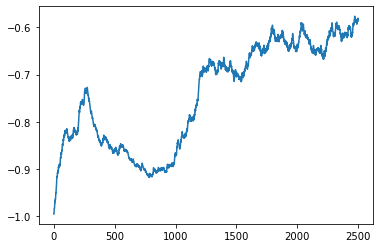

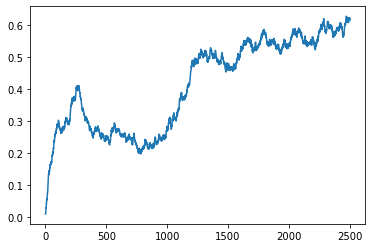

In [22]:
import matplotlib.pyplot as plt

with open(os.path.join(CHECKPOINT_DIR, 'scores.pkl'), 'rb') as f:
    score_list = pickle.load(f)
plt.plot(score_list)
plt.savefig(os.path.join(CHECKPOINT_DIR, 'scores.png'))
plt.show()

with open(os.path.join(CHECKPOINT_DIR, 'completion.pkl'), 'rb') as f:
    completion_list = pickle.load(f)
plt.plot(completion_list)
plt.savefig(os.path.join(CHECKPOINT_DIR, 'completion.png'))
plt.show()